In [1]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cuda')

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import re

1. load dataset

In [3]:
# Download the text file "Alice's Adventures in Wonderland" from Project Gutenberg
#!mkdir -p ../datasets/wonderland
#!wget -O ../datasets/wonderland/wonderland.txt https://www.gutenberg.org/ebooks/11.txt.utf-8


In [4]:

# Load the text data from the downloaded file
filename = "../datasets/wonderland/wonderland.txt"
with open(filename, 'r', encoding='utf-8') as f:
  raw_text = f.read()

# Convert all characters to lowercase
raw_text = raw_text.lower()

# Remove non-alphanumeric characters
raw_text = re.sub(r'\n', ' ', raw_text)
raw_text = re.sub(r'[^A-Za-z ]+', '', raw_text)

print(raw_text[500:700])
# Create a set of unique characters in the text
unique_chars = set(raw_text)

# Sort the unique characters
chars = sorted(list(unique_chars))

# Create a dictionary mapping each unique character to a unique integer
char_to_int = dict((c, i) for i, c in enumerate(chars))

# Split the text into training and testing sets
train_start = int(len(raw_text) * 0.1)  # Starting index for training set (10% of text)
train_end = int(len(raw_text) * 0.8)  # Ending index for training set (80% of text)
test_start = train_end  # Starting index for testing set (remaining 20% of text)

raw_text_train = raw_text[train_start:train_end]  # Extract training text
raw_text_test = raw_text[test_start:]  # Extract testing text

# Calculate and print some summary statistics
n_chars_train = len(raw_text_train)
n_chars_test = len(raw_text_test)
n_vocab = len(chars)

print("Total Characters train:", n_chars_train)
print("Total Characters test:", n_chars_test)
print("Total Unique Characters (Vocabulary Size):", n_vocab)
print("Chars: ",chars)

ok  title alices adventures in wonderland  author lewis carroll  release date june   ebook                  most recently updated february    language english  credits arthur dibianca and david widger
Total Characters train: 108293
Total Characters test: 30941
Total Unique Characters (Vocabulary Size): 27
Chars:  [' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


Prepare the dataset of input to output pairs encoded as integers.

The model takes input sequences of 100 characters and predicts the character 101

In [5]:
# Define the sequence length for character prediction
seq_length = 100

# List to store sequences of characters as integer indices
dataX = []

# List to store target characters (next character) as integer indices
dataY = []

# Loop through the training text with a stride of 1 character
for i in range(0, n_chars_train - seq_length, 1):
  # Extract an input sequence of length 'seq_length' from the training text
  seq_in = raw_text_train[i:i + seq_length]

  # Extract the target character (next character to predict)
  seq_out = raw_text_train[i + seq_length]

  # Convert characters in the input sequence to their integer indices using the mapping dictionary
  dataX.append([char_to_int[char] for char in seq_in])

  # Append the target character's integer index to the output list
  dataY.append(char_to_int[seq_out])

# Count the total number of training patterns (sequences-target character pairs)
n_patterns = len(dataX)
print("Total Patterns train: ", n_patterns)

# Convert the lists of integer indices (dataX and dataY) into PyTorch tensors
X_train = torch.tensor(dataX, dtype=torch.float32)
y_train = torch.tensor(dataY)

# Reshape the input sequences into a 3D tensor with dimensions:
#   - n_patterns: Number of training patterns
#   - seq_length: Length of the input sequence
#   - 1: Number of features (one-hot encoded characters can be represented as floats here)
X_train = X_train.reshape(n_patterns, seq_length, 1)

# Normalize the input sequences by dividing each element by the vocabulary size
# This helps the training process of the model
X_train = X_train / float(n_vocab)

# Prepare testing data (similar to training data preparation)

y_train = torch.tensor(dataY)

#test
dataX = []
dataY = []
for i in range(0, n_chars_test - seq_length, 1):
    seq_in = raw_text_test[i:i + seq_length]
    seq_out = raw_text_test[i + seq_length]
    dataX.append([char_to_int[char] for char in seq_in])
    dataY.append(char_to_int[seq_out])
n_patterns = len(dataX)
print("Total Patterns test: ", n_patterns)
# Convert the testing data lists to tensors, reshape, normalize, and create target tensor
X_test = torch.tensor(dataX, dtype=torch.float32).reshape(n_patterns, seq_length, 1)
X_test = X_test / float(n_vocab)
y_test = torch.tensor(dataY)


Total Patterns train:  108193
Total Patterns test:  30841


# Model definition.

[LSTM](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html#torch.nn.LSTM)

[Explain](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)

[Multi layers](https://www.researchgate.net/publication/324600237/figure/fig5/AS:616974627385344@1524109622521/Multivariate-LSTM-with-4-features-and-a-single-output-The-output-of-LSTM-at-time-t-is.png)

In [49]:
class CharModelBiLSTM(nn.Module):


  def __init__(self, n_vocab):

    super().__init__()  # Call the superclass constructor

    # Define the LSTM layer
    self.lstm = nn.LSTM(
        input_size=1,  # Input size: one-hot encoded characters (represented as floats here)
        hidden_size=512,  # Hidden size of the LSTM layer
        num_layers=6,  # Number of LSTM layers stacked on top of each other
        batch_first=True,  # Input tensors are of shape (batch_size, seq_len, features)
        dropout=0.2,  # Dropout rate for regularization
        bidirectional=True  # Do not use bidirectional LSTM
    )


    self.linear = nn.Linear(1024, n_vocab)  # Map LSTM output to vocabulary size (number of characters)


  def forward(self, x):

    x, _ = self.lstm(x)
    # Take only the last output from the sequence (represents the model's prediction based on the entire sequence)
    x = x[:, -1, :]  # Select the last element from the sequence dimension

    # Pass the LSTM output through the linear layer to get logits for the next character prediction
    x = self.linear(x)

    return x


In [50]:
class CharModelLSTM(nn.Module):


  def __init__(self, n_vocab):

    super().__init__()  # Call the superclass constructor

    # Define the LSTM layer
    self.lstm = nn.LSTM(
        input_size=1,  # Input size: one-hot encoded characters (represented as floats here)
        hidden_size=256,  # Hidden size of the LSTM layer
        num_layers=6,  # Number of LSTM layers stacked on top of each other
        batch_first=True,  # Input tensors are of shape (batch_size, seq_len, features)
        dropout=0.2,  # Dropout rate for regularization
        bidirectional=False  # Do not use bidirectional LSTM
    )

    self.linear = nn.Linear(256, n_vocab)  # Map LSTM output to vocabulary size (number of characters)


  def forward(self, x):

    x, _ = self.lstm(x)
    # Take only the last output from the sequence (represents the model's prediction based on the entire sequence)
    x = x[:, -1, :]  # Select the last element from the sequence dimension

    # Pass the LSTM output through the linear layer to get logits for the next character prediction
    x = self.linear(x)

    return x


In [7]:
class CharModelGRU(nn.Module):
    def __init__(self, n_vocab):

        super().__init__()  # Call the superclass constructor
        self.gru = nn.GRU(
            input_size=1,  # Input size: one-hot encoded characters (represented as floats here)
            hidden_size=512,  # Hidden size of the LSTM layer
            num_layers=6,  # Number of LSTM layers stacked on top of each other
            batch_first=True,  # Input tensors are of shape (batch_size, seq_len, features)
            dropout=0.2,  # Dropout rate for regularization
            bidirectional=True  # Set to False for unidirectional LSTM
        )
        
        self.linear = nn.Linear(1024, n_vocab)
        
    def forward(self, x):
        x, _ = self.gru(x)
        x = x[:, -1, :]
        x = self.linear(x)
        return x
    

In [8]:
class CharModelRNN(nn.Module):
    def __init__(self, n_vocab):

        super().__init__()  # Call the superclass constructor
    
        self.rnn = nn.RNN(
            input_size=1,  # Input size: one-hot encoded characters (represented as floats here)
            hidden_size=512,  # Hidden size of the LSTM layer
            num_layers=6,  # Number of LSTM layers stacked on top of each other
            batch_first=True,  # Input tensors are of shape (batch_size, seq_len, features)
            dropout=0.2,  # Dropout rate for regularization
            bidirectional=True  # Set to False for unidirectional LSTM
        )

        self.linear = nn.Linear(1024, n_vocab)
        
    def forward(self, x):
        x, _ = self.rnn(x)
        x = x[:, -1, :]
        x = self.linear(x)
        return x
    

Train setup and dataloader

Train the model

In [9]:
from tqdm import tqdm
import pickle

def train(model, optimizer, loss_fn, n_epochs, loader_train, loader_test, name):
  best_model = None
  best_loss = np.inf
  patience = 23
  train_total_losses = []
  validation_total_losses = []

  for epoch in (range(n_epochs)):
    model.train()
    train_losses = []

    for X_batch, y_batch in tqdm(loader_train):

      optimizer.zero_grad()

      y_pred = model(X_batch.to(device))
      loss = loss_fn(y_pred, y_batch.to(device))
      train_losses.append(loss.cpu().detach().numpy())
      train_total_losses.append(loss.cpu().detach().numpy())

      loss.backward()
      optimizer.step()
    print("Epoch %d: Cross-entropy: %.4f" % (epoch, np.mean(train_losses)))
    model.eval()
    validation_losses = []


    with torch.no_grad():
      for X_batch, y_batch in tqdm(loader_test):
        y_pred = model(X_batch.to(device))
        validation_loss = loss_fn(y_pred.to(device), y_batch.to(device)).cpu()
        validation_losses.append(validation_loss)
        validation_total_losses.append(validation_loss)

      avg_validation_loss = np.mean(validation_losses)

      if avg_validation_loss < best_loss:
        best_loss = avg_validation_loss
        best_model = model.state_dict()
        torch.save([best_model, char_to_int], f"best_{name}.pth")
        patience = 30
        print("**BEST**", end="")
      else:
        patience -= 1

      torch.save([best_model, char_to_int], f"last_{name}.pth")

      print("Epoch %d: Validation Cross-entropy: %.4f" % (epoch, avg_validation_loss))

      if patience <= 0:
        print("Stop training!")
        break
      
  with open(f"val_{name}_losses.pkl", "wb") as f:
    pickle.dump(validation_total_losses, f)
  with open(f"train_{name}_losses.pkl", "wb") as f:
    pickle.dump(train_total_losses, f)
  print("Done")


In [10]:

n_epochs = 20  
batch_size = 512  

loader_train = data.DataLoader(
    data.TensorDataset(X_train, y_train), 
    shuffle=True,  
    batch_size=batch_size  
)


loader_test = data.DataLoader(
    data.TensorDataset(X_test, y_test),
    shuffle=False,  
    batch_size=batch_size  
)


model = CharModelBiLSTM(n_vocab).to(device)
model.to(device)
train(model, optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5), nn.CrossEntropyLoss(), n_epochs, loader_train, loader_test, "lstm")
del model
torch.cuda.empty_cache()
torch.cuda.synchronize()


model = CharModelGRU(n_vocab).to(device)
model.to(device)
train(model, optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5), nn.CrossEntropyLoss(), n_epochs, loader_train, loader_test, "gru")
del model   
torch.cuda.empty_cache()
torch.cuda.synchronize()


model = CharModelRNN(n_vocab).to(device)
model.to(device)
train(model, optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5), nn.CrossEntropyLoss(), n_epochs, loader_train, loader_test, "rnn")
del model
torch.cuda.empty_cache()
torch.cuda.synchronize()

/home/omirako/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 212/212 [01:35<00:00,  2.22it/s]


Epoch 0: Cross-entropy: 2.8162


100%|██████████| 61/61 [00:08<00:00,  7.44it/s]


**BEST**Epoch 0: Validation Cross-entropy: 2.8081


100%|██████████| 212/212 [01:34<00:00,  2.25it/s]


Epoch 1: Cross-entropy: 2.4639


100%|██████████| 61/61 [00:08<00:00,  7.62it/s]


**BEST**Epoch 1: Validation Cross-entropy: 2.5078


100%|██████████| 212/212 [01:33<00:00,  2.26it/s]


Epoch 2: Cross-entropy: 2.1887


100%|██████████| 61/61 [00:07<00:00,  7.63it/s]


**BEST**Epoch 2: Validation Cross-entropy: 2.4020


100%|██████████| 212/212 [01:31<00:00,  2.31it/s]


Epoch 3: Cross-entropy: 2.0256


100%|██████████| 61/61 [00:07<00:00,  7.64it/s]


**BEST**Epoch 3: Validation Cross-entropy: 2.2972


100%|██████████| 212/212 [01:33<00:00,  2.27it/s]


Epoch 4: Cross-entropy: 1.9191


100%|██████████| 61/61 [00:08<00:00,  7.60it/s]


**BEST**Epoch 4: Validation Cross-entropy: 2.2630


100%|██████████| 212/212 [01:33<00:00,  2.27it/s]


Epoch 5: Cross-entropy: 1.8358


100%|██████████| 61/61 [00:07<00:00,  7.63it/s]


**BEST**Epoch 5: Validation Cross-entropy: 2.1676


100%|██████████| 212/212 [01:32<00:00,  2.30it/s]


Epoch 6: Cross-entropy: 1.7775


100%|██████████| 61/61 [00:07<00:00,  8.00it/s]


**BEST**Epoch 6: Validation Cross-entropy: 2.1660


100%|██████████| 212/212 [01:29<00:00,  2.37it/s]


Epoch 7: Cross-entropy: 1.7115


100%|██████████| 61/61 [00:07<00:00,  7.98it/s]


Epoch 7: Validation Cross-entropy: 2.1662


100%|██████████| 212/212 [01:29<00:00,  2.36it/s]


Epoch 8: Cross-entropy: 1.6550


100%|██████████| 61/61 [00:07<00:00,  7.71it/s]


**BEST**Epoch 8: Validation Cross-entropy: 2.1293


100%|██████████| 212/212 [01:31<00:00,  2.31it/s]


Epoch 9: Cross-entropy: 1.6035


100%|██████████| 61/61 [00:08<00:00,  7.62it/s]


**BEST**Epoch 9: Validation Cross-entropy: 2.0872


100%|██████████| 212/212 [01:33<00:00,  2.27it/s]


Epoch 10: Cross-entropy: 1.5670


100%|██████████| 61/61 [00:07<00:00,  7.63it/s]


**BEST**Epoch 10: Validation Cross-entropy: 2.0606


100%|██████████| 212/212 [01:33<00:00,  2.27it/s]


Epoch 11: Cross-entropy: 1.5262


100%|██████████| 61/61 [00:08<00:00,  7.62it/s]


**BEST**Epoch 11: Validation Cross-entropy: 2.0591


100%|██████████| 212/212 [01:33<00:00,  2.27it/s]


Epoch 12: Cross-entropy: 1.4940


100%|██████████| 61/61 [00:08<00:00,  7.62it/s]


**BEST**Epoch 12: Validation Cross-entropy: 2.0395


100%|██████████| 212/212 [01:33<00:00,  2.27it/s]


Epoch 13: Cross-entropy: 1.4479


100%|██████████| 61/61 [00:08<00:00,  7.62it/s]


Epoch 13: Validation Cross-entropy: 2.0866


100%|██████████| 212/212 [01:33<00:00,  2.26it/s]


Epoch 14: Cross-entropy: 1.4187


100%|██████████| 61/61 [00:08<00:00,  7.62it/s]


Epoch 14: Validation Cross-entropy: 2.0431


100%|██████████| 212/212 [01:33<00:00,  2.27it/s]


Epoch 15: Cross-entropy: 1.4012


100%|██████████| 61/61 [00:08<00:00,  7.62it/s]


Epoch 15: Validation Cross-entropy: 2.0544


100%|██████████| 212/212 [01:33<00:00,  2.26it/s]


Epoch 16: Cross-entropy: 1.3601


100%|██████████| 61/61 [00:08<00:00,  7.62it/s]


Epoch 16: Validation Cross-entropy: 2.0533


100%|██████████| 212/212 [01:33<00:00,  2.27it/s]


Epoch 17: Cross-entropy: 1.3426


100%|██████████| 61/61 [00:07<00:00,  7.64it/s]


Epoch 17: Validation Cross-entropy: 2.0992


100%|██████████| 212/212 [01:33<00:00,  2.26it/s]


Epoch 18: Cross-entropy: 1.3169


100%|██████████| 61/61 [00:07<00:00,  7.63it/s]


Epoch 18: Validation Cross-entropy: 2.0720


100%|██████████| 212/212 [01:33<00:00,  2.27it/s]


Epoch 19: Cross-entropy: 1.2814


100%|██████████| 61/61 [00:08<00:00,  7.62it/s]


Epoch 19: Validation Cross-entropy: 2.0408
Done


100%|██████████| 212/212 [01:19<00:00,  2.67it/s]


Epoch 0: Cross-entropy: 2.7279


100%|██████████| 61/61 [00:07<00:00,  8.63it/s]


**BEST**Epoch 0: Validation Cross-entropy: 2.6620


100%|██████████| 212/212 [01:19<00:00,  2.66it/s]


Epoch 1: Cross-entropy: 2.1856


100%|██████████| 61/61 [00:07<00:00,  8.62it/s]


**BEST**Epoch 1: Validation Cross-entropy: 2.3716


100%|██████████| 212/212 [01:19<00:00,  2.67it/s]


Epoch 2: Cross-entropy: 1.8450


100%|██████████| 61/61 [00:07<00:00,  8.63it/s]


**BEST**Epoch 2: Validation Cross-entropy: 2.2049


100%|██████████| 212/212 [01:19<00:00,  2.67it/s]


Epoch 3: Cross-entropy: 1.6470


100%|██████████| 61/61 [00:07<00:00,  8.63it/s]


**BEST**Epoch 3: Validation Cross-entropy: 2.1400


100%|██████████| 212/212 [01:19<00:00,  2.67it/s]


Epoch 4: Cross-entropy: 1.5137


100%|██████████| 61/61 [00:07<00:00,  8.59it/s]


**BEST**Epoch 4: Validation Cross-entropy: 2.1231


100%|██████████| 212/212 [01:19<00:00,  2.67it/s]


Epoch 5: Cross-entropy: 1.4203


100%|██████████| 61/61 [00:07<00:00,  8.64it/s]


**BEST**Epoch 5: Validation Cross-entropy: 2.1175


100%|██████████| 212/212 [01:20<00:00,  2.65it/s]


Epoch 6: Cross-entropy: 1.3478


100%|██████████| 61/61 [00:07<00:00,  8.63it/s]


Epoch 6: Validation Cross-entropy: 2.1648


100%|██████████| 212/212 [01:20<00:00,  2.64it/s]


Epoch 7: Cross-entropy: 1.2822


100%|██████████| 61/61 [00:07<00:00,  8.56it/s]


Epoch 7: Validation Cross-entropy: 2.1608


100%|██████████| 212/212 [01:15<00:00,  2.80it/s]


Epoch 8: Cross-entropy: 1.2225


100%|██████████| 61/61 [00:06<00:00,  9.03it/s]


Epoch 8: Validation Cross-entropy: 2.2381


100%|██████████| 212/212 [01:15<00:00,  2.79it/s]


Epoch 9: Cross-entropy: 1.1636


100%|██████████| 61/61 [00:06<00:00,  9.03it/s]


Epoch 9: Validation Cross-entropy: 2.2571


100%|██████████| 212/212 [01:16<00:00,  2.77it/s]


Epoch 10: Cross-entropy: 1.1139


100%|██████████| 61/61 [00:06<00:00,  8.96it/s]


Epoch 10: Validation Cross-entropy: 2.2335


100%|██████████| 212/212 [01:16<00:00,  2.78it/s]


Epoch 11: Cross-entropy: 1.0796


100%|██████████| 61/61 [00:06<00:00,  8.99it/s]


Epoch 11: Validation Cross-entropy: 2.3434


100%|██████████| 212/212 [01:15<00:00,  2.80it/s]


Epoch 12: Cross-entropy: 1.0349


100%|██████████| 61/61 [00:06<00:00,  9.88it/s]


Epoch 12: Validation Cross-entropy: 2.3139


100%|██████████| 212/212 [01:08<00:00,  3.08it/s]


Epoch 13: Cross-entropy: 0.9900


100%|██████████| 61/61 [00:06<00:00,  9.87it/s]


Epoch 13: Validation Cross-entropy: 2.3317


100%|██████████| 212/212 [01:08<00:00,  3.08it/s]


Epoch 14: Cross-entropy: 0.9446


100%|██████████| 61/61 [00:06<00:00,  9.88it/s]


Epoch 14: Validation Cross-entropy: 2.4514


100%|██████████| 212/212 [01:08<00:00,  3.08it/s]


Epoch 15: Cross-entropy: 0.9146


100%|██████████| 61/61 [00:06<00:00,  9.86it/s]


Epoch 15: Validation Cross-entropy: 2.4039


100%|██████████| 212/212 [01:08<00:00,  3.08it/s]


Epoch 16: Cross-entropy: 0.8743


100%|██████████| 61/61 [00:06<00:00,  9.86it/s]


Epoch 16: Validation Cross-entropy: 2.5004


100%|██████████| 212/212 [01:08<00:00,  3.08it/s]


Epoch 17: Cross-entropy: 0.8423


100%|██████████| 61/61 [00:06<00:00,  9.86it/s]


Epoch 17: Validation Cross-entropy: 2.5286


100%|██████████| 212/212 [01:08<00:00,  3.08it/s]


Epoch 18: Cross-entropy: 0.8055


100%|██████████| 61/61 [00:06<00:00,  9.88it/s]


Epoch 18: Validation Cross-entropy: 2.5964


100%|██████████| 212/212 [01:08<00:00,  3.08it/s]


Epoch 19: Cross-entropy: 0.7747


100%|██████████| 61/61 [00:06<00:00,  9.87it/s]


Epoch 19: Validation Cross-entropy: 2.6449
Done


100%|██████████| 212/212 [00:25<00:00,  8.24it/s]


Epoch 0: Cross-entropy: 2.9401


100%|██████████| 61/61 [00:02<00:00, 26.52it/s]


**BEST**Epoch 0: Validation Cross-entropy: 2.8762


100%|██████████| 212/212 [00:25<00:00,  8.23it/s]


Epoch 1: Cross-entropy: 2.8192


100%|██████████| 61/61 [00:02<00:00, 26.41it/s]


**BEST**Epoch 1: Validation Cross-entropy: 2.8601


100%|██████████| 212/212 [00:25<00:00,  8.24it/s]


Epoch 2: Cross-entropy: 2.6632


100%|██████████| 61/61 [00:02<00:00, 26.51it/s]


**BEST**Epoch 2: Validation Cross-entropy: 2.7599


100%|██████████| 212/212 [00:25<00:00,  8.26it/s]


Epoch 3: Cross-entropy: 2.5913


100%|██████████| 61/61 [00:02<00:00, 26.57it/s]


**BEST**Epoch 3: Validation Cross-entropy: 2.7357


100%|██████████| 212/212 [00:25<00:00,  8.28it/s]


Epoch 4: Cross-entropy: 2.5884


100%|██████████| 61/61 [00:02<00:00, 26.57it/s]


**BEST**Epoch 4: Validation Cross-entropy: 2.7177


100%|██████████| 212/212 [00:25<00:00,  8.30it/s]


Epoch 5: Cross-entropy: 2.5480


100%|██████████| 61/61 [00:02<00:00, 26.64it/s]


**BEST**Epoch 5: Validation Cross-entropy: 2.6962


100%|██████████| 212/212 [00:25<00:00,  8.31it/s]


Epoch 6: Cross-entropy: 2.5107


100%|██████████| 61/61 [00:02<00:00, 26.59it/s]


**BEST**Epoch 6: Validation Cross-entropy: 2.6392


100%|██████████| 212/212 [00:25<00:00,  8.32it/s]


Epoch 7: Cross-entropy: 2.4932


100%|██████████| 61/61 [00:02<00:00, 26.62it/s]


Epoch 7: Validation Cross-entropy: 2.6505


100%|██████████| 212/212 [00:25<00:00,  8.32it/s]


Epoch 8: Cross-entropy: 2.4558


100%|██████████| 61/61 [00:02<00:00, 26.60it/s]


**BEST**Epoch 8: Validation Cross-entropy: 2.5998


100%|██████████| 212/212 [00:25<00:00,  8.31it/s]


Epoch 9: Cross-entropy: 2.4070


100%|██████████| 61/61 [00:02<00:00, 26.56it/s]


**BEST**Epoch 9: Validation Cross-entropy: 2.5787


100%|██████████| 212/212 [00:25<00:00,  8.31it/s]


Epoch 10: Cross-entropy: 2.3713


100%|██████████| 61/61 [00:02<00:00, 26.58it/s]


**BEST**Epoch 10: Validation Cross-entropy: 2.5395


100%|██████████| 212/212 [00:25<00:00,  8.32it/s]


Epoch 11: Cross-entropy: 2.3538


100%|██████████| 61/61 [00:02<00:00, 26.63it/s]


**BEST**Epoch 11: Validation Cross-entropy: 2.4999


100%|██████████| 212/212 [00:25<00:00,  8.33it/s]


Epoch 12: Cross-entropy: 2.3112


100%|██████████| 61/61 [00:02<00:00, 26.60it/s]


Epoch 12: Validation Cross-entropy: 2.5179


100%|██████████| 212/212 [00:25<00:00,  8.34it/s]


Epoch 13: Cross-entropy: 2.2524


100%|██████████| 61/61 [00:02<00:00, 26.61it/s]


**BEST**Epoch 13: Validation Cross-entropy: 2.4865


100%|██████████| 212/212 [00:25<00:00,  8.33it/s]


Epoch 14: Cross-entropy: 2.2114


100%|██████████| 61/61 [00:02<00:00, 26.53it/s]


**BEST**Epoch 14: Validation Cross-entropy: 2.4402


100%|██████████| 212/212 [00:25<00:00,  8.34it/s]


Epoch 15: Cross-entropy: 2.1629


100%|██████████| 61/61 [00:02<00:00, 26.65it/s]


**BEST**Epoch 15: Validation Cross-entropy: 2.3884


100%|██████████| 212/212 [00:25<00:00,  8.34it/s]


Epoch 16: Cross-entropy: 2.1634


100%|██████████| 61/61 [00:02<00:00, 26.63it/s]


**BEST**Epoch 16: Validation Cross-entropy: 2.3799


100%|██████████| 212/212 [00:25<00:00,  8.34it/s]


Epoch 17: Cross-entropy: 2.1300


100%|██████████| 61/61 [00:02<00:00, 26.47it/s]


Epoch 17: Validation Cross-entropy: 2.3832


100%|██████████| 212/212 [00:25<00:00,  8.34it/s]


Epoch 18: Cross-entropy: 2.1054


100%|██████████| 61/61 [00:02<00:00, 26.53it/s]


**BEST**Epoch 18: Validation Cross-entropy: 2.3732


100%|██████████| 212/212 [00:25<00:00,  8.32it/s]


Epoch 19: Cross-entropy: 2.0980


100%|██████████| 61/61 [00:02<00:00, 26.51it/s]


**BEST**Epoch 19: Validation Cross-entropy: 2.3410
Done


3. Generate text with the model


In [19]:
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F

# Load the best model and character mapping dictionary
model = CharModelGRU(n_vocab)
best_model, char_to_int = torch.load("last_gru.pth")
temperature = 0.5
n_vocab = len(char_to_int)

# Create a dictionary for converting integer indices back to characters
int_to_char = dict((i, c) for c, i in char_to_int.items())


model.load_state_dict(best_model)
model.to(device)

np.random.seed(0)
starts = np.random.randint(0, len(raw_text)-seq_length, 10)

model.eval()


for s in starts:
  prompt = raw_text[s:s+seq_length]
  pattern = [char_to_int[c] for c in prompt]

  print(f"Sequence {s}")
  print('\tPrompt: "%s"' % prompt)
  print("\tGenerated: ", end="")
  softmax = nn.Softmax(dim=1)

  with torch.no_grad():  # Disable gradient calculation for efficiency
    for i in range(500):
      x = np.reshape(pattern, (1, len(pattern), 1)) / float(n_vocab)
      x = torch.tensor(x, dtype=torch.float32)
      x = x.to(device)
      
      prediction = model(x)
      prediction = prediction / temperature
      
      probabilities = F.softmax(prediction, dim=-1)
      sample = torch.multinomial(probabilities, num_samples=1)
      index = sample.item()
      
      #index = int(prediction.argmax())
      result = int_to_char[index]

      # Print the generated character
      print(result, end="")

      # Update the pattern for the next iteration:
      #   - Append the predicted character index to the pattern list
      #   - Slice the pattern list to keep the most recent sequence length characters
      pattern.append(index)
      pattern = pattern[1:]
  print("\n")
print("Done")

Sequence 43567
	Prompt: "up to rest herself and fanned herself with one of the leaves i should have liked teaching it tricks "
	Generated: and the words did not get close to her to see the lock turtle and held it all round the lory and then and then round it a caucusrace was talking to a seasonable pace of the lomy  as she went on in the said to herself if one only alice began to see this she went bother she knew the others  to her about it and the sest of the lobsters and then said the king and dont be an old cone with the dormouse and four times severely i said the hatter  it executes noticed alice and some of the bottom of a wel

Sequence 117952
	Prompt: "hispered in reply for fear they should forget them before the end of the trial  stupid things alice "
	Generated: i knew when i got tp see if she added as all the pigeon in the distance  and yet i wish i had of them at last the gryphon  i never heard of sule and to on one who was pales the duchess did and broke to them and then the

**ASSIGNMENT**

Modify the LSTM network with [RNN or GRU](https://pytorch.org/docs/stable/nn.html#recurrent-layers)  and analyze the results exploring variations in the number of layers, hidden state dimensions, dropout rates, and other relevant parameters.

In [24]:
# save the dicts:
import pickle

# load the dicts

val_loss_pickle_lstm = pickle.load(open("val_lstm_losses.pkl", "rb"))
train_loss_pickle_lstm = pickle.load(open("train_lstm_losses.pkl", "rb"))
val_loss_pickle_gru = pickle.load(open("val_gru_losses.pkl", "rb")) 
train_loss_pickle_gru = pickle.load(open("train_gru_losses.pkl", "rb"))
val_loss_pickle_rnn = pickle.load(open("val_rnn_losses.pkl", "rb"))
train_loss_pickle_rnn = pickle.load(open("train_rnn_losses.pkl", "rb"))

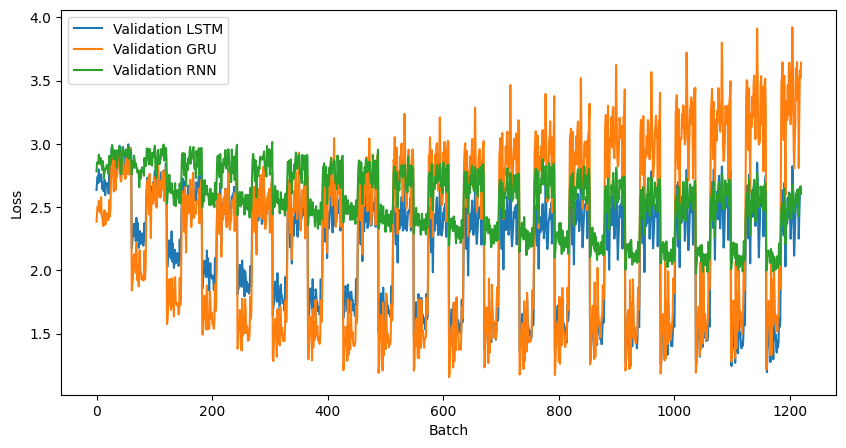

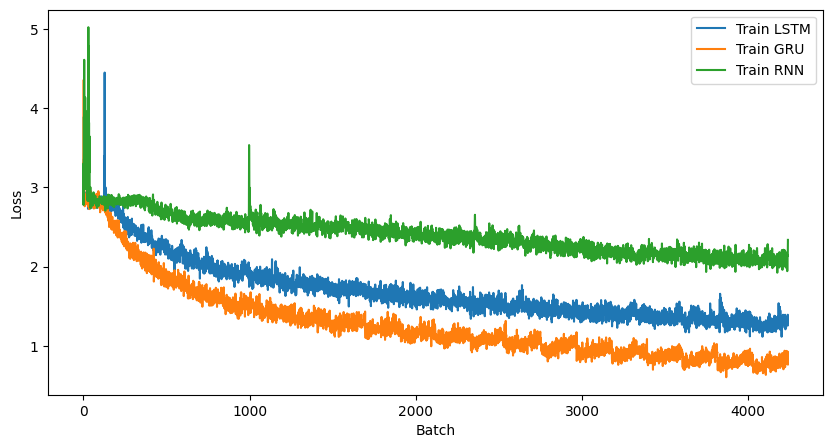

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(val_loss_pickle_lstm, label="Validation LSTM")
plt.plot(val_loss_pickle_gru, label="Validation GRU")
plt.plot(val_loss_pickle_rnn, label="Validation RNN")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.legend()

plt.figure(figsize=(10, 5))
plt.plot(train_loss_pickle_lstm, label="Train LSTM")
plt.plot(train_loss_pickle_gru, label="Train GRU")
plt.plot(train_loss_pickle_rnn, label="Train RNN")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [45]:
from torchsummary import summary

gru = CharModelGRU(n_vocab).to(device)
summary(gru, input_size=(1,1));

rnn = CharModelRNN(n_vocab).to(device)
summary(rnn, input_size=(1,1));

bilstm = CharModelBiLSTM(n_vocab).to(device)
#summary(bilstm, input_size=(1,1));

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
               GRU-1  [[-1, 1, 1024], [-1, 2, 512]]               0
            Linear-2                   [-1, 27]          27,675
Total params: 27,675
Trainable params: 27,675
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 8.00
Params size (MB): 0.11
Estimated Total Size (MB): 8.11
----------------------------------------------------------------
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
               RNN-1  [[-1, 1, 1024], [-1, 2, 512]]               0
            Linear-2                   [-1, 27]          27,675
Total params: 27,675
Trainable params: 27,675
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forwar

In [46]:
def generate_text(model, raw_text, char_to_int, int_to_char, seq_length, num_predictions, prediction_length, temperature=0.5, random_seed=None):
  if random_seed is not None: np.random.seed(random_seed)
  starts = np.random.randint(0, len(raw_text)-seq_length, num_predictions)

  model.eval()
  results = []
  pbar = tqdm(starts, desc=f"{model.__class__.__name__} | Generating {num_predictions} sequences")

  for s in starts:
    prompt = raw_text[s:s+seq_length]
    pattern = [char_to_int[c] for c in prompt]
    softmax = nn.Softmax(dim=1)
    buffer = ""
    with torch.no_grad():
      for i in range(prediction_length):
        x = np.reshape(pattern, (1, len(pattern), 1)) / float(n_vocab)
        x = torch.tensor(x, dtype=torch.float32)
        x = x.to(device)
        
        prediction = model(x)
        prediction = prediction / temperature
        
        probabilities = F.softmax(prediction, dim=-1)
        sample = torch.multinomial(probabilities, num_samples=1)
        index = sample.item()

        buffer += int_to_char[index]
        # print(int_to_char[index], end="")
        pattern.append(index)
        pattern = pattern[1:]

    results.append(buffer)
    pbar.update(1)

  return results

In [51]:
# Load the best model and character mapping dictionary
weights_paths = ["last_lstm.pth", "last_gru.pth", "last_rnn.pth"]

models = [CharModelBiLSTM(n_vocab), CharModelGRU(n_vocab), CharModelRNN(n_vocab)]
results = []
for model, pth_path in zip(models, weights_paths):
    weights, char_to_int = torch.load(pth_path)
    model.load_state_dict(weights)
    model.to(device)
    
    temperature = 0.5
    n_vocab = len(char_to_int)
    num_predictions = 100
    prediction_length = 350
    
    int_to_char = dict((i, c) for c, i in char_to_int.items())

    results.append(generate_text(model, raw_text, char_to_int, int_to_char, seq_length, num_predictions, prediction_length, temperature=temperature))

CharModelBiLSTM | Generating 100 sequences: 100%|██████████| 100/100 [05:57<00:00,  3.58s/it]
CharModelGRU | Generating 100 sequences: 100%|██████████| 100/100 [04:47<00:00,  2.88s/it]
CharModelRNN | Generating 100 sequences: 100%|██████████| 100/100 [03:34<00:00,  2.14s/it]


In [52]:
results

[['hog a bould her way all the said the door began seemed to say  how the fardeners it as the cat said the cat said the queen was said the cat of her the duchess so be a cone down and she was now and she thought alice in a little and then the same the hatter and the hame of the said the door and she was noly know sook and the was the did not peally i ',
  'first sole she rool and the way what when the conversation all that all she said the king and the cat said the mock turtle said the queen was the said the door she said the queen and the rat the same the trembled her to large bear dining and say what the rand the mock turtle said the right and she had no the said the dormouse not in a vords was tha',
  'ch a little said the cat and she was not at all said the cat  i shall you what ill have a door as the room and the pigeon and the sabbit and and the asked  i dont interesting in cone alice was said the mock turtle seen the first had not said the said the gryphon and the skates in the 

In [53]:
import text_analysis as analysis

models_ewr = []
models_uwr = []
for result in results:
    ewr = []
    uwr = []
    for i, predicted in enumerate(result):
        ewr.append(analysis.english_words_ratio(predicted))
        uwr.append(analysis.unique_words_ratio(predicted))
        print(f"Predicted text: {predicted}")
        print(f"English word rateo: {ewr[i]}")
        print(f"Unique words rateo: {uwr[i]}")
        print(f"")
    models_ewr.append(ewr)
    models_uwr.append(uwr)

Predicted text: hog a bould her way all the said the door began seemed to say  how the fardeners it as the cat said the cat said the queen was said the cat of her the duchess so be a cone down and she was now and she thought alice in a little and then the same the hatter and the hame of the said the door and she was noly know sook and the was the did not peally i 
English word rateo: 0.9240506329113924
Unique words rateo: 0.5569620253164557

Predicted text: first sole she rool and the way what when the conversation all that all she said the king and the cat said the mock turtle said the queen was the said the door she said the queen and the rat the same the trembled her to large bear dining and say what the rand the mock turtle said the right and she had no the said the dormouse not in a vords was tha
English word rateo: 0.9594594594594594
Unique words rateo: 0.527027027027027

Predicted text: ch a little said the cat and she was not at all said the cat  i shall you what ill have a doo

In [54]:
# get unique words rateo from real sections 
num_analyzed_sections = 1000
np.random.seed(69)
sections_idx = np.random.randint(0, len(raw_text)-seq_length, num_analyzed_sections).astype(int)

uwr_true = []
for idx in sections_idx:
    section = analysis.remove_non_english(''.join([c for c in raw_text[idx: idx+seq_length]]))
    uwr_true.append(analysis.unique_words_ratio(section))
np_uwr_true = np.array(uwr_true)
print(f"mean: {np_uwr_true.mean()} | std: {np_uwr_true.std()}")

models_uwr.append(uwr_true)
models_uwr[0], models_uwr[1], models_uwr[2] = models_uwr[2], models_uwr[0], models_uwr[1]

mean: 0.9150922592985977 | std: 0.07247842456061897


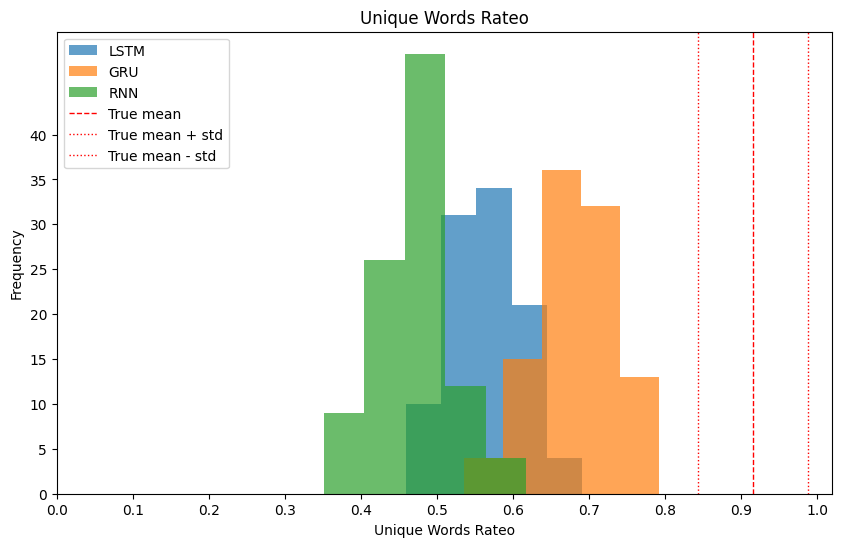

In [55]:
plt.figure(figsize=(10, 6))
plt.title("Unique Words Rateo")
plt.hist(models_uwr[1], label='LSTM', alpha=0.7, bins=5)
plt.hist(models_uwr[2], label='GRU', alpha=0.7, bins=5)
plt.hist(models_uwr[0], label='RNN', alpha=0.7, bins=5)
plt.axvline(np.array(uwr_true).mean(), color='r', linestyle='dashed', linewidth=1, label='True mean')
plt.axvline(np.array(uwr_true).mean() + np.array(uwr_true).std(), color='r', linestyle='dotted', linewidth=1, label='True mean + std')
plt.axvline(np.array(uwr_true).mean() - np.array(uwr_true).std(), color='r', linestyle='dotted', linewidth=1, label='True mean - std')
plt.xticks(np.arange(0, 1.1, 0.1))
plt.yticks(np.arange(0, 45, 5))
plt.xlabel("Unique Words Rateo")
plt.ylabel("Frequency")
plt.legend(loc='upper left')
plt.show()

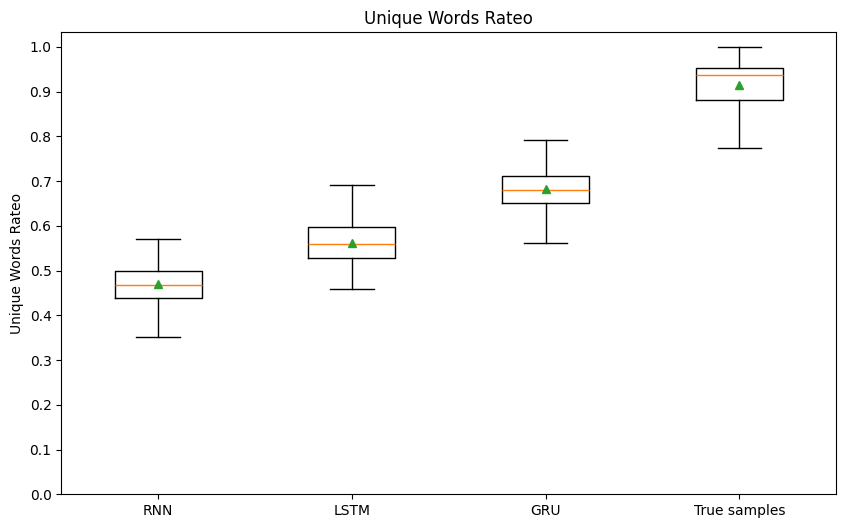

In [56]:
# Box plot for unique words rateo
plt.figure(figsize=(10, 6))
plt.tight_layout()
plt.title("Unique Words Rateo")
plt.boxplot(models_uwr, labels=['RNN', 'LSTM', 'GRU', 'True samples'], showmeans=True, showfliers=False)
# horizontal line
# plt.axhline(uwr_true.median(), color='r', linestyle='dashed', linewidth=1, label='True median')
# plt.axhline(uwr_true.median() + uwr_true.std(), color='r', linestyle='dotted', linewidth=1, label='True median + std')
# plt.axhline(uwr_true.median() - uwr_true.std(), color='r', linestyle='dotted', linewidth=1, label='True median - std')
plt.yticks(np.arange(0, 1.1, 0.1))
plt.ylabel("Unique Words Rateo")
plt.show()

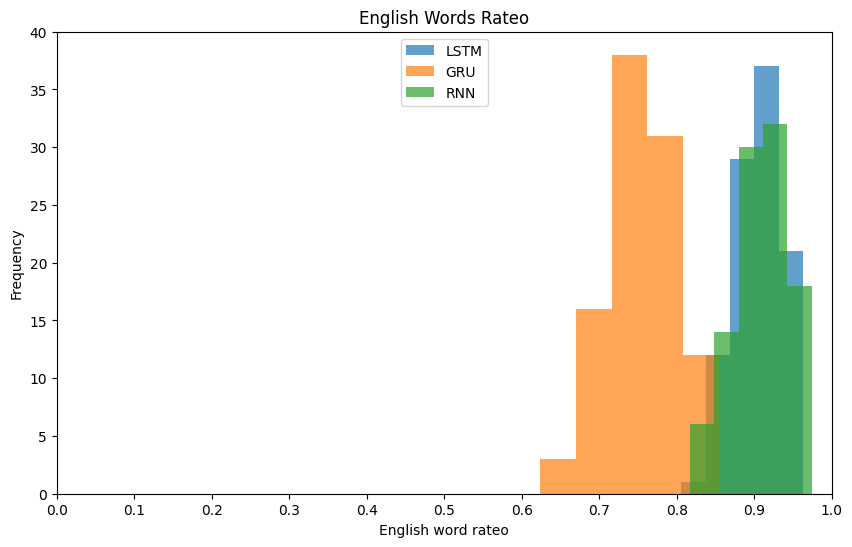

In [57]:
plt.figure(figsize=(10, 6))
plt.title("English Words Rateo")
plt.hist(models_ewr[1], label='LSTM', alpha=0.7, bins=5)
plt.hist(models_ewr[2], label='GRU', alpha=0.7, bins=5)
plt.hist(models_ewr[0], label='RNN', alpha=0.7, bins=5)
plt.xlabel("English word rateo")
plt.ylabel("Frequency")
plt.legend(loc='upper center')
plt.xticks(np.arange(0, 1.1, 0.1))
plt.yticks(np.arange(0, 45, 5))
plt.show()

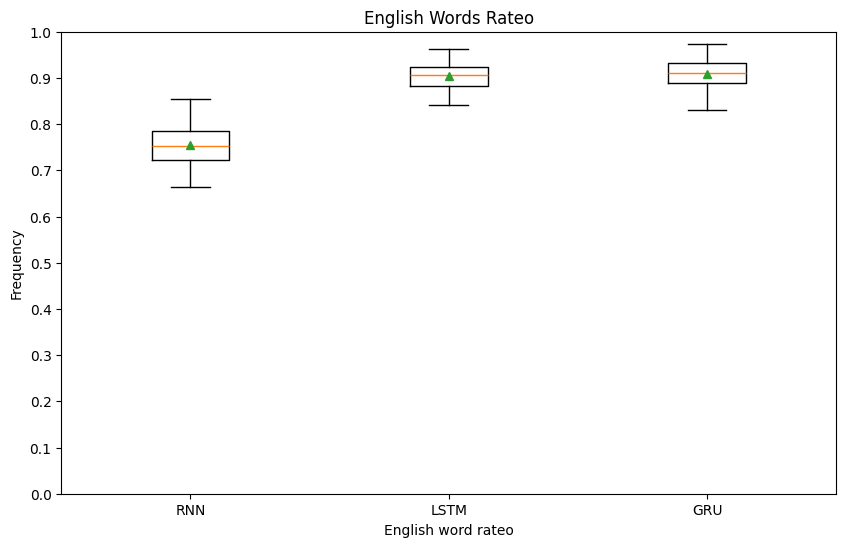

In [85]:

#models_ewr[0], models_ewr[1], models_ewr[2] = models_ewr[2], models_ewr[1], models_ewr[0]
plt.figure(figsize=(10, 6))
plt.title("English Words Rateo")
plt.boxplot(models_ewr, labels=['RNN', 'LSTM', 'GRU'], showmeans=True, showfliers=False)
plt.xlabel("English word rateo")
plt.ylabel("Frequency")
plt.yticks(np.arange(0, 1.1, .1))
plt.show()